In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp
from scipy.io import loadmat, savemat
from statsmodels.stats.multitest import fdrcorrection

In [2]:
#load epicenter maps
epicenter_version='4modes_dataHansenSSC'

tmp  = loadmat(f'D:\\OneDrive\\5_TMS_response\\Epicenter\\SC\\epicenterMap_TMS_avgranking_S4007Net_{epicenter_version}.mat')
epicenterMaps_TMS = tmp['my_array'].squeeze()


#load behavioral response maps of the active group
tmp  = loadmat(f'D:\\OneDrive\\7_Treatment_response\\stimulation_site\\responseMap_IndiFC_inverse.mat')
re_vas_indi = tmp['re_vas_indi'].squeeze()
re_ccqg_indi = tmp['re_ccqg_indi'].squeeze()
re_ccqn_indi = tmp['re_ccqn_indi'].squeeze()
re_hars_indi = tmp['re_hars_indi'].squeeze()
re_hdrs_indi = tmp['re_hdrs_indi'].squeeze()
re_psqi_indi = tmp['re_psqi_indi'].squeeze()


clinical_data_indi2 = pd.DataFrame({
    'VAS_indi': re_vas_indi.squeeze(),
    'CCQN_indi': re_ccqn_indi.squeeze(),
})


In [3]:
#### the final model in the manuscript
X = clinical_data_indi2.copy()
y = epicenterMaps_TMS
# add a constant term
X = sm.add_constant(X)

# construct linear models
model_C = sm.OLS(y, X).fit()
# print the results
print(model_C.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     19.29
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           1.01e-08
Time:                        11:42:17   Log-Likelihood:                -2391.2
No. Observations:                 400   AIC:                             4788.
Df Residuals:                     397   BIC:                             4800.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        176.6379      6.280     28.129      0.0

In [4]:
# Extract the p-values for each regression coefficient (excluding the intercept)
pvals = model_C.pvalues[1:]  

# FDR correction
rejected, pvals_corrected = fdrcorrection(pvals, alpha=0.05)

# print the final results
fdr_results = pd.DataFrame({
    'Term': pvals.index,
    'Raw p-value': pvals.values,
    'FDR corrected p-value': pvals_corrected,
    'Significant (FDR)': rejected
})
print(fdr_results)


        Term  Raw p-value  FDR corrected p-value  Significant (FDR)
0   VAS_indi     0.000009               0.000018               True
1  CCQN_indi     0.000109               0.000109               True


In [7]:
## Visualization the associations 

def plot_associations(x, y,name_to_save=None,xstart=None,xend=None):
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    import os
    import seaborn as sns

    plt.figure(figsize=(6, 5)) 

    sns.kdeplot(x=x,y=y,fill=True,cmap='Greys',levels=30,alpha=0.9)
    sns.regplot(x=x,
                y=y,
                scatter=False,
                truncate=False,color="black",ci=None,
                line_kws={'linewidth':2})   

    plt.ylabel('y')
    plt.xlabel('x')
    # Remove NaN values from both vectors
    valid_indices = ~np.isnan(x) & ~np.isnan(y)
    cleaned_regional_atrophy = x[valid_indices]
    cleaned_average_neighbor_atrophy = y[valid_indices]
    r, p = stats.pearsonr(cleaned_regional_atrophy,
                           cleaned_average_neighbor_atrophy)
    print(r)
    plt.annotate(f'r = {r:.2f}',
                 xy = (0.7, 0.9),
                 xycoords = 'axes fraction')
    plt.tight_layout()
    plt.xlim(xstart, xend)
    
    current_dir = os.getcwd()
    if name_to_save:
        plt.savefig(os.path.join(current_dir, name_to_save + '.pdf'),dpi = 300)

C:\Users\123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


-0.2312505683488238


C:\Users\123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


-0.20528553535599636


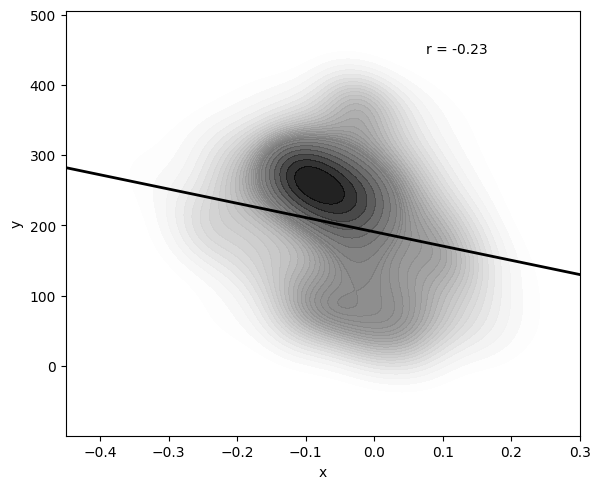

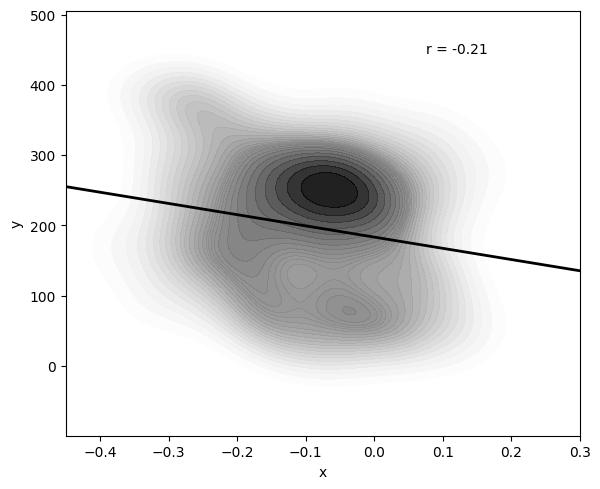

In [8]:
plot_associations(x=re_vas_indi, y=epicenterMaps_TMS,name_to_save='relation_VAS_dataHansenSSC',xstart=-0.45,xend=0.3)
plot_associations(x=re_ccqn_indi, y=epicenterMaps_TMS,name_to_save='relation_CCQN_dataHansenSSC',xstart=-0.45,xend=0.3)